In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import r2_score
from sklearn.linear_model import SGDRegressor, LassoCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import mutual_info_regression, SelectKBest
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import joblib

# Exploratory Data Analysis and Model Building

In [3]:
df = pd.read_csv('static/2023_01_to_04.csv', index_col=0)
display(df.head())
print(df.shape)

,resale_price,year,month,timeseries_month,region,town,rooms,avg_storey,floor_area_sqm,remaining_lease
_id,,,,,,,,,,
150072,298000.0,2023,4,2023-04-01,North-East,Ang Mo Kio,2.0,8.0,44.0,53.750000
152257,865000.0,2023,4,2023-04-01,North,Yishun,5.5,11.0,142.0,63.833333
152256,780000.0,2023,4,2023-04-01,North,Yishun,5.5,11.0,142.0,62.166667
152255,935000.0,2023,4,2023-04-01,North,Yishun,5.5,5.0,164.0,68.166667
152254,892000.0,2023,4,2023-04-01,North,Yishun,5.5,2.0,169.0,68.333333


(8861, 10)


## 1. EDA
### Summary of actions before training

1. Handling null values and Checking for collinearity
2. Preprocessing (mean encoding)
3. Feature selection (KBest, Lasso regression)
4. Model selection
5. Hyperparameter tuning 

### 1.1 Handling null values

In [4]:
#display(df[df['dist_to_station'].isna()])
df.dropna(inplace=True)

In [5]:
display(df.isna().sum())

resale_price        0
year                0
month               0
timeseries_month    0
region              0
town                0
rooms               0
avg_storey          0
floor_area_sqm      0
remaining_lease     0
dtype: int64

### Explanation for each feature

| Feature           | Explanation                                                                                     |
|-------------------|-------------------------------------------------------------------------------------------------|
| resale_price      | Dependent variable, the selling price of the flat                                               |
| region            | Region of the flat                                                                              |
| town              | Town district of the flat                                                                       |
| rooms             | Number of rooms in the flat (whole numbers except for 4.5, which represents an executive flat with an extra study/balcony) |
| avg_storey        | Mean value of the floor range (intervals of 3 storeys)                                          |
| floor_area_sqm    | Total floor area (in square meters) of the flat                                                 |
| remaining_lease   | Remaining lease of the flat in months                                                           |
| dist_to_station   | Distance in meters to the nearest MRT (Mass Rapid Transit) station                              |
| min_pt_time       | Time in seconds to reach the nearest MRT station by public transport and walking                |


### 1.1 Checking for collinearity among numerical features
* There is strong collinearity between 
    * floor_area_sqm and rooms (0.86)
    * dist_to_station and min_pt_time (0.69)
* Even much so higher than their correlation with output (resale price)
* For linear models, we need to remove one of each pair of feature to ensure that there is no multicollinearity, for this I will remove the feature with lower Pearson's correlation with our output
    * rooms (0.65)
    * min_pt_time (0.69)

<Axes: >

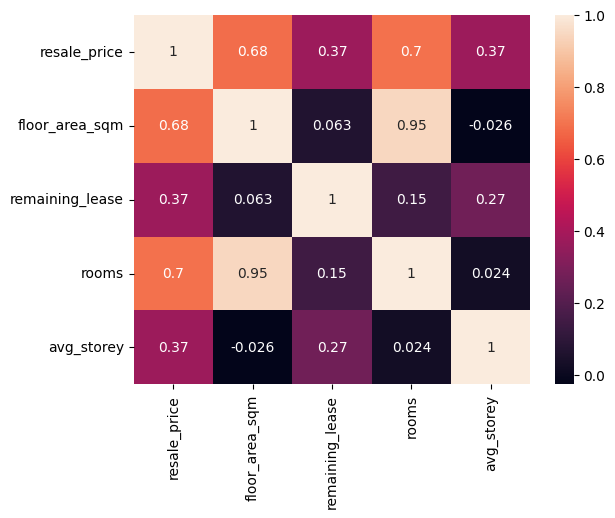

In [6]:
numerical_columns = df[['resale_price', 'floor_area_sqm', 'remaining_lease', 'rooms', 'avg_storey']] #, 'dist_to_station', 'min_pt_time']]
sns.heatmap(numerical_columns.corr(), annot=True)

#### What are the most expensive neighbourhoods?

Each neighbourhood has a different mean price due to a non-exhaustive number of factors:

* location
* infrastructure and amenitites
* affluent / less affluent neighbourhoods
* supply and demand
* market speculation  

In [7]:
region_prices = df.groupby(['region', 'rooms'])[['resale_price']].median(numeric_only=True).sort_values(by=['region','rooms'], ascending=False)
region_prices = region_prices.unstack()
region_prices.columns = ['1 room', '2 room', '3 room', '4 room', '5 room', 'Executive', 'Mansionette']
region_prices.style.format(precision=0, thousands=',').highlight_max(color='red').highlight_min(color='green')

,1 room,2 room,3 room,4 room,5 room,Executive,Mansionette
region,,,,,,,
Central,"238,500","270,000","385,000","755,000","885,000","1,030,000",nan
East,nan,"346,500","389,444","542,000","656,500","840,000",nan
North,nan,"322,000","388,000","490,000","600,000","768,000","1,080,000"
North-East,nan,"330,000","406,500","560,888","650,000","820,000",nan
West,nan,"320,000","375,000","500,000","619,000","750,000",nan


In [8]:
town_prices = df.groupby(['town', 'rooms'])[['resale_price']].median(numeric_only=True).sort_values(by=['town','rooms'], ascending=False)
town_prices = town_prices.unstack()
town_prices.columns = ['1 room', '2 room', '3 room', '4 room', '5 room', 'Executive', 'Mansionette']
town_prices.style.format(precision=0, thousands=',').highlight_max(color='red').highlight_min(color='green')

,1 room,2 room,3 room,4 room,5 room,Executive,Mansionette
town,,,,,,,
Ang Mo Kio,nan,"289,900","380,000","560,000","780,000","933,000",nan
Bedok,nan,"285,000","365,000","490,000","660,000","870,000",nan
Bishan,nan,nan,"460,000","685,000","900,000","1,050,000",nan
Bukit Batok,nan,"339,000","370,000","590,000","760,000","820,000",nan
Bukit Merah,"238,500","270,000","394,000","815,000","870,000",nan,nan
Bukit Panjang,nan,"302,500","380,500","490,000","620,000","796,888",nan
Bukit Timah,nan,nan,"465,000","777,500","985,000","1,288,000",nan
Central Area,nan,"328,000","447,400","884,000","1,340,000",nan,nan
Choa Chu Kang,nan,"307,500","411,500","490,000","582,000","715,000",nan


#### Change in resale prices within year 2023

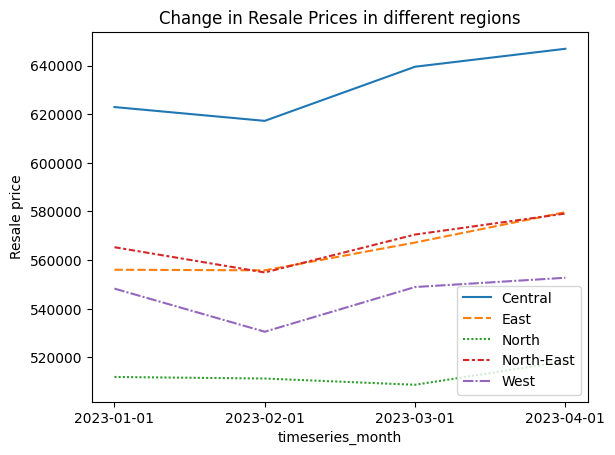

In [9]:
ma_df = df.groupby(['timeseries_month', 'region'])['resale_price'].mean()
ma_df = ma_df.unstack()
sns.lineplot(ma_df)
plt.title('Change in Resale Prices in different regions')
plt.ylabel('Resale price')
plt.legend(loc='lower right')
plt.show()

### 1.2 Preprocessing (mean and label encoding)
* I will perform mean encoding (resale_price) onto the town and rooms.
* Take note that mean encoding may sometimes result in overfitting.

In [10]:
# Label encoding for town
encoder = LabelEncoder()
town_encoded = pd.Series(encoder.fit_transform(df['town']), name='town_encoded', index=df.index)

# Label encoding for region
region_encoded = pd.Series(encoder.fit_transform(df['region']), name='region_encoded', index=df.index)

In [11]:
# Mean encoding through mapping groupby dictionary onto pd.Series
def columns_to_tuple(df):
    '''
    Function to combined town and rooms as a tuple for dictionary mapping
    '''
    return (df['town'],  df['rooms'])

# Get the dictionary of the town and rooms for mean encoding
town_mean_dict = df.groupby(['town', 'rooms'])['resale_price'].mean(numeric_only=True).to_dict()
town_tuple = df.apply(columns_to_tuple, axis=1)
town_tuple.name = 'mean_price_by_town_rooms'

# Encode through mapping
town_mean_price = town_tuple.map(town_mean_dict)
train_df = pd.concat([numerical_columns, town_mean_price, town_encoded, region_encoded], axis =1)
train_df.head()


,resale_price,floor_area_sqm,remaining_lease,rooms,avg_storey,mean_price_by_town_rooms,town_encoded,region_encoded
_id,,,,,,,,
150072,298000.0,44.0,53.750000,2.0,8.0,293168.800000,0,3
152257,865000.0,142.0,63.833333,5.5,11.0,838167.676364,25,2
152256,780000.0,142.0,62.166667,5.5,11.0,838167.676364,25,2
152255,935000.0,164.0,68.166667,5.5,5.0,838167.676364,25,2
152254,892000.0,169.0,68.333333,5.5,2.0,838167.676364,25,2


### 1.3 Feature selection

In [12]:
X_unscaled = train_df.iloc[:,1:]
y = train_df.iloc[:,0]
scaler = MinMaxScaler()
X = scaler.fit_transform(X_unscaled)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

SelectKBest using Mutual Information

In [13]:
X_df = pd.DataFrame(X, columns=X_unscaled.columns)
kbest = SelectKBest(score_func=mutual_info_regression, k='all')
kbest.fit(X_df, y)
pd.DataFrame(kbest.scores_, index=kbest.get_feature_names_out(kbest.feature_names_in_), columns=['Mutual Info Score'])

,Mutual Info Score
floor_area_sqm,0.728665
remaining_lease,0.333599
rooms,0.525595
avg_storey,0.080430
mean_price_by_town_rooms,0.887720
town_encoded,0.219721
region_encoded,0.089023


Lasso regularisation to determine less important features

In [14]:
# LassoCV here uses crossvalidation to determine the optimum alpha (penalty value)
lr_reg1 = LassoCV(random_state=42)
lr_reg1.fit(X_train, y_train)
r2 = r2_score(y_test, lr_reg1.predict(X_test))
print(f'Selected Alpha from CV: {np.round(lr_reg1.alpha_,3)}')
print(f'Bias: \t\t{np.round(lr_reg1.intercept_,3)}')
display(pd.DataFrame(lr_reg1.coef_, index=X_unscaled.columns, columns=['Features']))

Selected Alpha from CV: 20.031
Bias: 		203818.986


,Features
floor_area_sqm,594485.359254
remaining_lease,191362.693812
rooms,-298265.152154
avg_storey,241499.277709
mean_price_by_town_rooms,722403.134937
town_encoded,-53654.114240
region_encoded,-76217.766096


#### Final selection of features

Based on all the investigation done so far, the following features will be excluded:
* rooms
* dist_to_station

In [15]:
X_unscaled = train_df[['floor_area_sqm', 'remaining_lease', 'avg_storey', 'mean_price_by_town_rooms']] #, 'min_pt_time'
y = train_df.iloc[:,0]
scaler = MinMaxScaler()
X = scaler.fit_transform(X_unscaled)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 1.4 Model Selection
We will compare the following models in general, before hyperparameter tuning
* SGD Regressor
* Decision Tree Regressor
* Random Forest Regressor
* Gradient Boosting Regressor

In [16]:
models = {'SGD Regressor' : SGDRegressor(random_state=42),
          'Tree Regressor' : DecisionTreeRegressor(random_state=42),
          'Random Forest Regressor' : RandomForestRegressor(random_state=42), 
          'Gradient Boosting Regressor' : GradientBoostingRegressor(random_state=42)}

for name, model in models.items():
    model.fit(X_train, y_train)
    r2 = r2_score(y_test, model.predict(X_test))
    print(f'R2 score for {name}: {np.round(r2,3)}')

R2 score for SGD Regressor: 0.842
R2 score for Tree Regressor: 0.901
R2 score for Random Forest Regressor: 0.94
R2 score for Gradient Boosting Regressor: 0.902


In [17]:
feature_importances = {}
for name, model in models.items():
    if name == 'SGD Regressor':
        continue
    feature_importances[name]= model.feature_importances_

print('Feature Importances')
display(pd.DataFrame(feature_importances, index=X_unscaled.columns))

Feature Importances


,Tree Regressor,Random Forest Regressor,Gradient Boosting Regressor
floor_area_sqm,0.192020,0.182454,0.110383
remaining_lease,0.148622,0.139326,0.131665
avg_storey,0.043690,0.049061,0.049945
mean_price_by_town_rooms,0.615668,0.629158,0.708007


The ensemble models (Random Forest and Gradient Boosting) tend to perform better. 
I will narrow down to tune these two models for now.

### 1.5 Hyperparameter tuning
Randomized Search Cross-Validation to tune the hyperpameters for the top 2 models

#### Random Forest Regressor

In [18]:
param_distributions = {'max_depth' : [None, 3,5,7,9],
                       'n_estimators' : [50,100,150]
                       }

random_cv = RandomizedSearchCV(estimator=RandomForestRegressor(random_state=42),
                               scoring= 'r2', 
                               param_distributions= param_distributions, 
                               n_iter= 15,
                               cv= 5, 
                               verbose= 1,
                               n_jobs=2)

random_cv.fit(X, y)
print('Best Parameters', random_cv.best_params_)
print('Best r2score', np.round(random_cv.best_score_,3))
best_rfr = random_cv.best_estimator_


Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best Parameters {'n_estimators': 100, 'max_depth': None}
Best r2score 0.934


#### Gradient Boosting Regressor

In [19]:
param_distributions = {'max_depth' : [None, 3,5,7,9],
                       'n_estimators' : [50,100,150],
                       'learning_rate' : [0.01,0.1,1]
                       }

random_cv = RandomizedSearchCV(estimator=GradientBoostingRegressor(random_state=42),
                               scoring= 'r2', 
                               param_distributions= param_distributions, 
                               n_iter= 15,
                               cv= 5, 
                               verbose= 1,
                               n_jobs=2)

random_cv.fit(X, y)
print('Best Parameters', random_cv.best_params_)
print('Best r2score', np.round(random_cv.best_score_,3))
best_gbc = random_cv.best_estimator_


Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best Parameters {'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.1}
Best r2score 0.936


## Test on subsequent month's data

In [25]:
test_df = pd.read_csv('static/2023_05.csv', index_col=0)

# Use previous dictionary of the town and rooms for mean encoding
town_tuple = test_df.apply(columns_to_tuple, axis=1)
town_tuple.name = 'mean_price_by_town_rooms'
town_mean_price = town_tuple.map(town_mean_dict)
test_df = pd.concat([test_df, town_mean_price], axis =1)
test_df = test_df[['resale_price','floor_area_sqm', 'remaining_lease', 'avg_storey', 'mean_price_by_town_rooms']]
display(test_df.head())
print(test_df.shape)

,resale_price,floor_area_sqm,remaining_lease,avg_storey,mean_price_by_town_rooms
_id,,,,,
152272,400000.0,73.0,54.75,2.0,399997.149425
152258,275000.0,44.0,53.75,2.0,293168.800000
152259,300000.0,45.0,61.75,8.0,293168.800000
152260,330000.0,68.0,56.75,2.0,399997.149425
152261,400000.0,67.0,54.75,8.0,399997.149425


(1857, 5)


In [26]:
X_test = test_df.iloc[:,1:]
y_test = test_df.iloc[:,0]
X_test = scaler.transform(X_test)

r2 = r2_score(y_test, best_rfr.predict(X_test))
print(f'R2 score for Random Forest Regressor: {np.round(r2,3)}')

r2 = r2_score(y_test, best_gbc.predict(X_test))
print(f'R2 score for Gradient Boosting Regressor: {np.round(r2,3)}')

R2 score for Random Forest Regressor: 0.935
R2 score for Gradient Boosting Regressor: 0.94


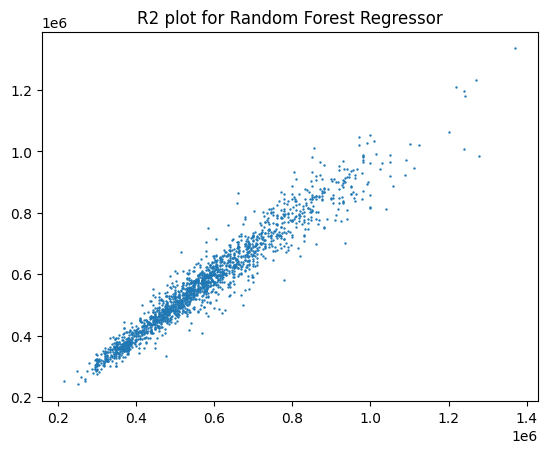

In [34]:
# Plot r2 graphs
plt.scatter(y_test,best_rfr.predict(X_test), marker='.', s=2)
plt.title('R2 plot for Random Forest Regressor')
plt.show()

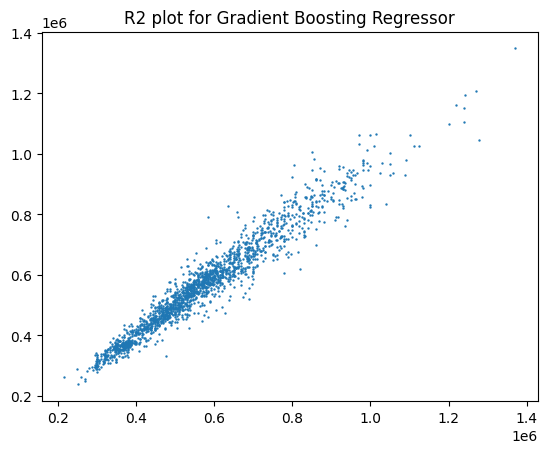

In [35]:
# Plot r2 graphs
plt.scatter(y_test,best_gbc.predict(X_test), marker='.', s=2)
plt.title('R2 plot for Gradient Boosting Regressor')
plt.show()

## Conclusion

In [21]:
#joblib.dump(best_gbc, 'models/apr2023_gbc.joblib')